# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
import tensorflow_datasets as tfds

(ds_train, ds_valid, ds_test), ds_info = tfds.load(
    name="svhn_cropped",
    split=['train', 'extra', 'test',],
    as_supervised=True,
    with_info=True,
    data_dir="~/tensorflow_datasets/"
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/73257 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/3.0.0.incomplete0G7YNH/svhn_cropped-train.tfrecord*...:   0%|…

Generating test examples...:   0%|          | 0/26032 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/3.0.0.incomplete0G7YNH/svhn_cropped-test.tfrecord*...:   0%| …

Generating extra examples...:   0%|          | 0/531131 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/3.0.0.incomplete0G7YNH/svhn_cropped-extra.tfrecord*...:   0%|…

Dataset svhn_cropped downloaded and prepared to /root/tensorflow_datasets/svhn_cropped/3.0.0. Subsequent calls will reuse this data.


In [3]:
ds_info

tfds.core.DatasetInfo(
    name='svhn_cropped',
    full_name='svhn_cropped/3.0.0',
    description="""
    The Street View House Numbers (SVHN) Dataset is an image digit recognition dataset of over 600,000 digit images coming from real world data. Images are cropped to 32x32.
    """,
    homepage='http://ufldl.stanford.edu/housenumbers/',
    data_path='/root/tensorflow_datasets/svhn_cropped/3.0.0',
    file_format=tfrecord,
    download_size=1.47 GiB,
    dataset_size=1.07 GiB,
    features=FeaturesDict({
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'extra': <SplitInfo num_examples=531131, num_shards=8>,
        'test': <SplitInfo num_examples=26032, num_shards=1>,
        'train': <SplitInfo num_examples=73257, num_shards=1>,
    },
    citation="""@article{Netzer2011,
    author = {Netzer, Yuval and W

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

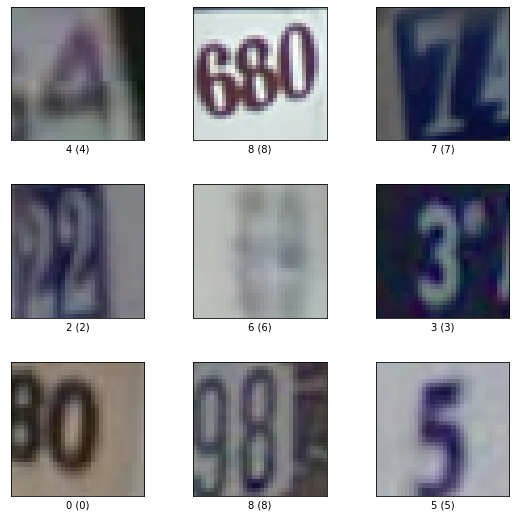

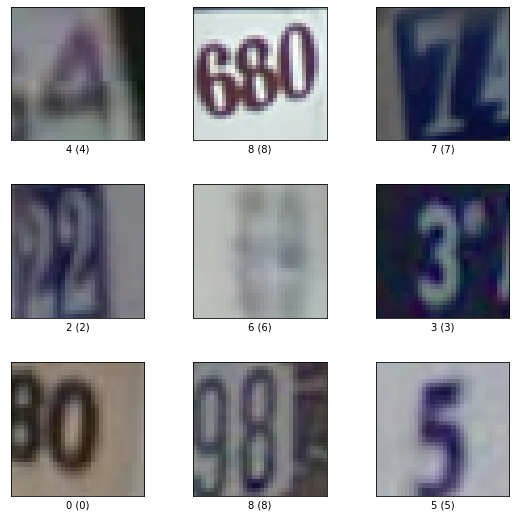

In [4]:
tfds.show_examples(ds_train, ds_info)

In [5]:
from tensorflow.image import rgb_to_grayscale


def preprocess(image, label):
    image = rgb_to_grayscale(image)
    return image, label

In [6]:
ds_train_prep = ds_train.map(preprocess)
ds_valid_prep = ds_valid.take(1000).map(preprocess)
ds_test_prep = ds_test.map(preprocess)

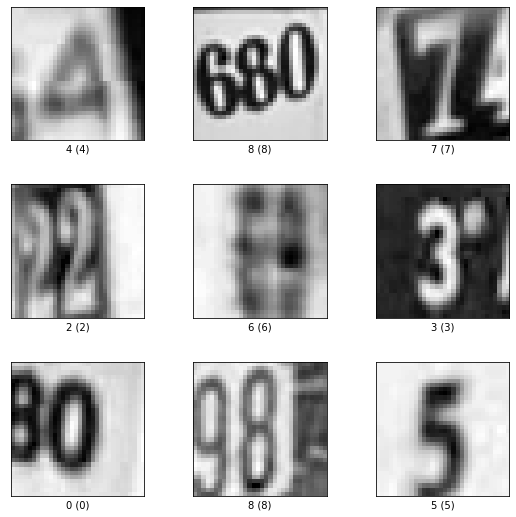

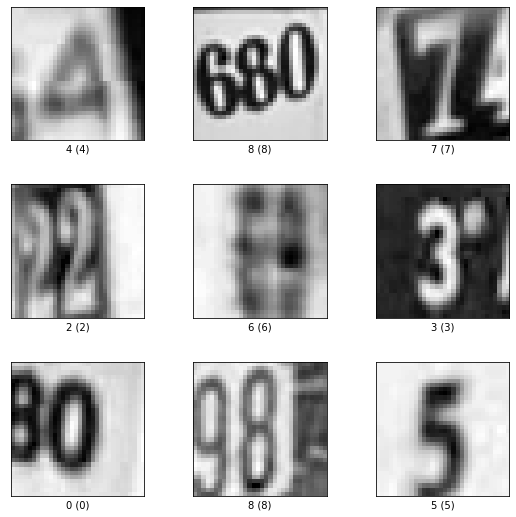

In [7]:
tfds.show_examples(ds_train_prep, ds_info)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense

num_classes = ds_info.features["label"].num_classes
layers = [
    Input(shape=(32, 32, 1)),
    Flatten(),
    Dense(units=256, kernel_initializer="he_normal", activation="relu"),
    Dense(units=128, kernel_initializer="he_normal", activation="relu"),
    Dense(units=64, kernel_initializer="he_normal", activation="relu"),
    Dense(units=64, kernel_initializer="he_normal", activation="relu"),
    Dense(units=num_classes, kernel_initializer="glorot_uniform", activation="softmax"),
]
mlp_model = Sequential(layers)
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                                 
Total params: 308,362
Trainable params: 308,362
Non-trai

In [9]:
import numpy as np


num_weigths_mlp = np.sum([np.prod(v.get_shape().as_list()) for v in mlp_model.trainable_variables])

In [10]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

mlp_model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [12]:
from tensorflow.data import AUTOTUNE


BATCH_SIZE = 64
EPOCHS = 30

ds_train_batched = ds_train_prep.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_valid_batched = ds_valid_prep.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_test_batched = ds_test_prep.batch(BATCH_SIZE).prefetch(AUTOTUNE)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath="svhn_checkpoint/mlp", save_weights_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2),
]

mlp_history = mlp_model.fit(
    ds_train_batched,
    validation_data=ds_valid_batched,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/30
1145/1145 [==============================] - 13s 11ms/step - loss: 1.8788 - accuracy: 0.3484 - val_loss: 1.6946 - val_accuracy: 0.3930
Epoch 2/30
1145/1145 [==============================] - 12s 10ms/step - loss: 1.6510 - accuracy: 0.4248 - val_loss: 1.6325 - val_accuracy: 0.4120
Epoch 3/30
1145/1145 [==============================] - 12s 10ms/step - loss: 1.5402 - accuracy: 0.4754 - val_loss: 1.4604 - val_accuracy: 0.4820
Epoch 4/30
1145/1145 [==============================] - 12s 10ms/step - loss: 1.4168 - accuracy: 0.5324 - val_loss: 1.3166 - val_accuracy: 0.5600
Epoch 5/30
1145/1145 [==============================] - 14s 12ms/step - loss: 1.3202 - accuracy: 0.5731 - val_loss: 1.0933 - val_accuracy: 0.6370
Epoch 6/30
1145/1145 [==============================] - 12s 10ms/step - loss: 1.2558 - accuracy: 0.5985 - val_loss: 1.0540 - val_accuracy: 0.6570
Epoch 7/30
1145/1145 [==============================] - 12s 10ms/step - loss: 1.2002 - accuracy: 0.6219 - val_loss: 0.9283 -

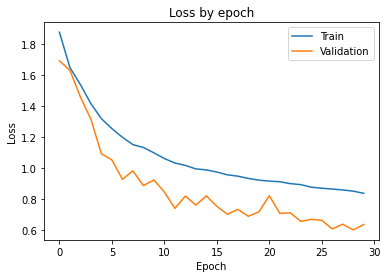

In [15]:
from matplotlib import pyplot as plt

plt.plot(mlp_history.history['loss'])
plt.plot(mlp_history.history['val_loss'])
plt.title("Loss by epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])

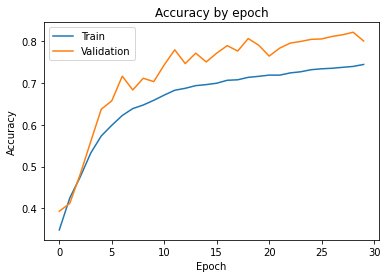

In [16]:
from matplotlib import pyplot as plt

plt.plot(mlp_history.history['accuracy'])
plt.plot(mlp_history.history['val_accuracy'])
plt.title("Accuracy by epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [42]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense


tf.keras.backend.clear_session()

num_classes = ds_info.features["label"].num_classes
layers = [
    Input(shape=(32, 32, 1)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", activation="relu"),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", activation="relu"),
    MaxPooling2D(),
    Conv2D(filters=16, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", activation="relu"),
    Flatten(),
    Dense(units=128, kernel_initializer="he_normal", activation="relu"),
    Dense(units=num_classes, kernel_initializer="glorot_uniform", activation="softmax"),
]
cnn_model = Sequential(layers)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          4624      
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [43]:
num_weigths_cnn = np.sum([np.prod(v.get_shape().as_list()) for v in cnn_model.trainable_variables])
print("Num weights CNN:", num_weigths_cnn)
print("Num weights MLP:", num_weigths_mlp)

Num weights CNN: 156218
Num weights MLP: 308362


In [44]:
from keras.losses import SparseCategoricalCrossentropy

cnn_model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [45]:
import tensorflow as tf

BATCH_SIZE = 64
EPOCHS = 30

ds_train_batched = ds_train_prep.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_valid_batched = ds_valid_prep.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test_batched = ds_test_prep.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath="svhn_checkpoint/cnn", save_weights_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2),
]

cnn_history = cnn_model.fit(
    ds_train_batched,
    validation_data=ds_valid_batched,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/30
1145/1145 [==============================] - 15s 13ms/step - loss: 3.3154 - accuracy: 0.2401 - val_loss: 1.2704 - val_accuracy: 0.5970 - lr: 0.0010
Epoch 2/30
1145/1145 [==============================] - 13s 12ms/step - loss: 1.0984 - accuracy: 0.6584 - val_loss: 0.8686 - val_accuracy: 0.6990 - lr: 0.0010
Epoch 3/30
1145/1145 [==============================] - 13s 12ms/step - loss: 0.8656 - accuracy: 0.7347 - val_loss: 0.6441 - val_accuracy: 0.7880 - lr: 0.0010
Epoch 4/30
1145/1145 [==============================] - 14s 12ms/step - loss: 0.7725 - accuracy: 0.7634 - val_loss: 0.5454 - val_accuracy: 0.8260 - lr: 0.0010
Epoch 5/30
1145/1145 [==============================] - 14s 13ms/step - loss: 0.7254 - accuracy: 0.7782 - val_loss: 0.5580 - val_accuracy: 0.8250 - lr: 0.0010
Epoch 6/30
1145/1145 [==============================] - 17s 15ms/step - loss: 0.6788 - accuracy: 0.7919 - val_loss: 0.4958 - val_accuracy: 0.8460 - lr: 0.0010
Epoch 7/30
1145/1145 [========================

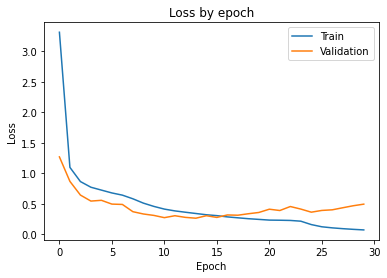

In [46]:
from matplotlib import pyplot as plt

plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title("Loss by epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])

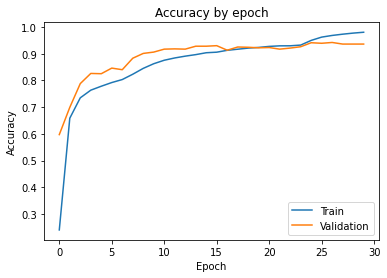

In [48]:
from matplotlib import pyplot as plt

plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title("Accuracy by epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])

## Comments

A bit of overfitting, but nothing that some weight regularization or dropout can't solve

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.